In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import pandas as pd
import numpy as np
import os
import sys
import glob
import calendar
import project_func as pf
import geopandas as gpd
import math
import pvlib
import matplotlib.pyplot as plt
project_root = pf.get_project_dir()

module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
from ipv_workbench.utilities import utils

In [3]:
future_weather_dir = os.path.join(project_root, 'weather_files', 'morphed')

hist_epw_files = glob.glob(os.path.join(project_root, 'weather_files', 'tmy3', '*.epw'))

cz = '1a'
hist_epw_file = [f for f in hist_epw_files if cz in f][0]
ssp126_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp126', 'EPWs', 'ssp126_50*.epw'))
ssp245_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp245', 'EPWs', 'ssp245_50*.epw'))
ssp585_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp585', 'EPWs', 'ssp585_50*.epw'))

In [4]:

climate_zones_shp = os.path.join(project_root, 'notebooks', 'input_data', 'climate_zones', 'ClimateZones.shp')

zones = gpd.read_file(climate_zones_shp)
zones = zones[~pd.isna(zones['State'])]
zones = zones[~pd.isna(zones['IECC21'])]
zones['Moisture21'] = zones['Moisture21'].fillna('A').str.lower()
zones['IECC21'] = zones['IECC21'].astype(int)
# change LA to 3bc
row_idx = zones[zones['Country']=='Los Angeles'].index[0]
zones.loc[row_idx,'Moisture21'] = 'bc'
zones['climate_zone'] = zones['IECC21'].astype(str) + zones['Moisture21']
zones = zones[zones['climate_zone']!='5c']
# zones = zones[zones['State']!='Hawaii']
zones = zones.to_crs(epsg=2163)
zones['cz_color'] = zones['climate_zone'].map(pf.get_color_dict())
# zones['grid_emissions'] = zones['climate_zone'].map(grid_ann_cz)


# Warm hours

In [5]:
delta_dict = {}

for cz in pf.get_cz_list():
    delta_dict[cz] = {}
    hist_epw_file = [f for f in hist_epw_files if cz in f][0]
    n_hours_g_26_hist = sum(utils.tmy_to_dataframe(hist_epw_file)['drybulb_C']>26)
    
    ssp126_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp126', 'EPWs', 'ssp126_50*.epw'))
    ssp245_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp245', 'EPWs', 'ssp245_50*.epw'))
    ssp585_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp585', 'EPWs', 'ssp585_50*.epw'))
    
    for year in pf.get_years():
        f_126 = pf.find_file(ssp126_epw_files, pf.get_year_bands(year))
        f_245 = pf.find_file(ssp245_epw_files, pf.get_year_bands(year))
        f_585 = pf.find_file(ssp585_epw_files, pf.get_year_bands(year))
        
        for ssp in [f_126, f_245, f_585]:
            n_hours_g_26_fut = sum(utils.tmy_to_dataframe(ssp)['drybulb_C']>26)
            scenario = ssp.split(os.sep)[-3]
            delta_dict[cz].update({f'{scenario}_{year}':n_hours_g_26_fut - n_hours_g_26_hist})

warm_hours_df = pd.DataFrame(delta_dict).transpose()

delta_126 = warm_hours_df[['ssp126_2080']].to_dict()['ssp126_2080']
delta_245 = warm_hours_df[['ssp245_2080']].to_dict()['ssp245_2080']
delta_585 = warm_hours_df[['ssp585_2080']].to_dict()['ssp585_2080']

In [6]:
zones['D_n26_126'] = zones['climate_zone'].map(delta_126)
zones['D_n26_245'] = zones['climate_zone'].map(delta_245)
zones['D_n26_585'] = zones['climate_zone'].map(delta_585)

zones.head()

,GEOID,Country,State,IECC15,IECC21,BA15,BA21,Moisture15,Moisture21,geometry,climate_zone,cz_color,D_n26_126,D_n26_245,D_n26_585
0,G37017,Bladen,North Carolina,3.0,3,Mixed-Humid,Mixed-Humid,A,a,"POLYGON ((1908594.508 -888691.896, 1917226.443...",3a,#c55912,960,1406,2298
1,G37167,Stanly,North Carolina,3.0,3,Mixed-Humid,Mixed-Humid,A,a,"POLYGON ((1759107.569 -883582.059, 1769852.587...",3a,#c55912,960,1406,2298
2,G39153,Summit,Ohio,5.0,5,Cold,Cold,A,a,"POLYGON ((1518816.335 -259402.244, 1515622.890...",5a,#32a02e,761,979,1679
3,G42113,Sullivan,Pennsylvania,5.0,5,Cold,Cold,A,a,"POLYGON ((1897285.293 -108013.083, 1945669.474...",5a,#32a02e,761,979,1679
4,G48459,Upshur,Texas,3.0,3,Hot-Humid,Hot-Humid,A,a,"POLYGON ((456109.472 -1356476.609, 454827.653 ...",3a,#c55912,960,1406,2298


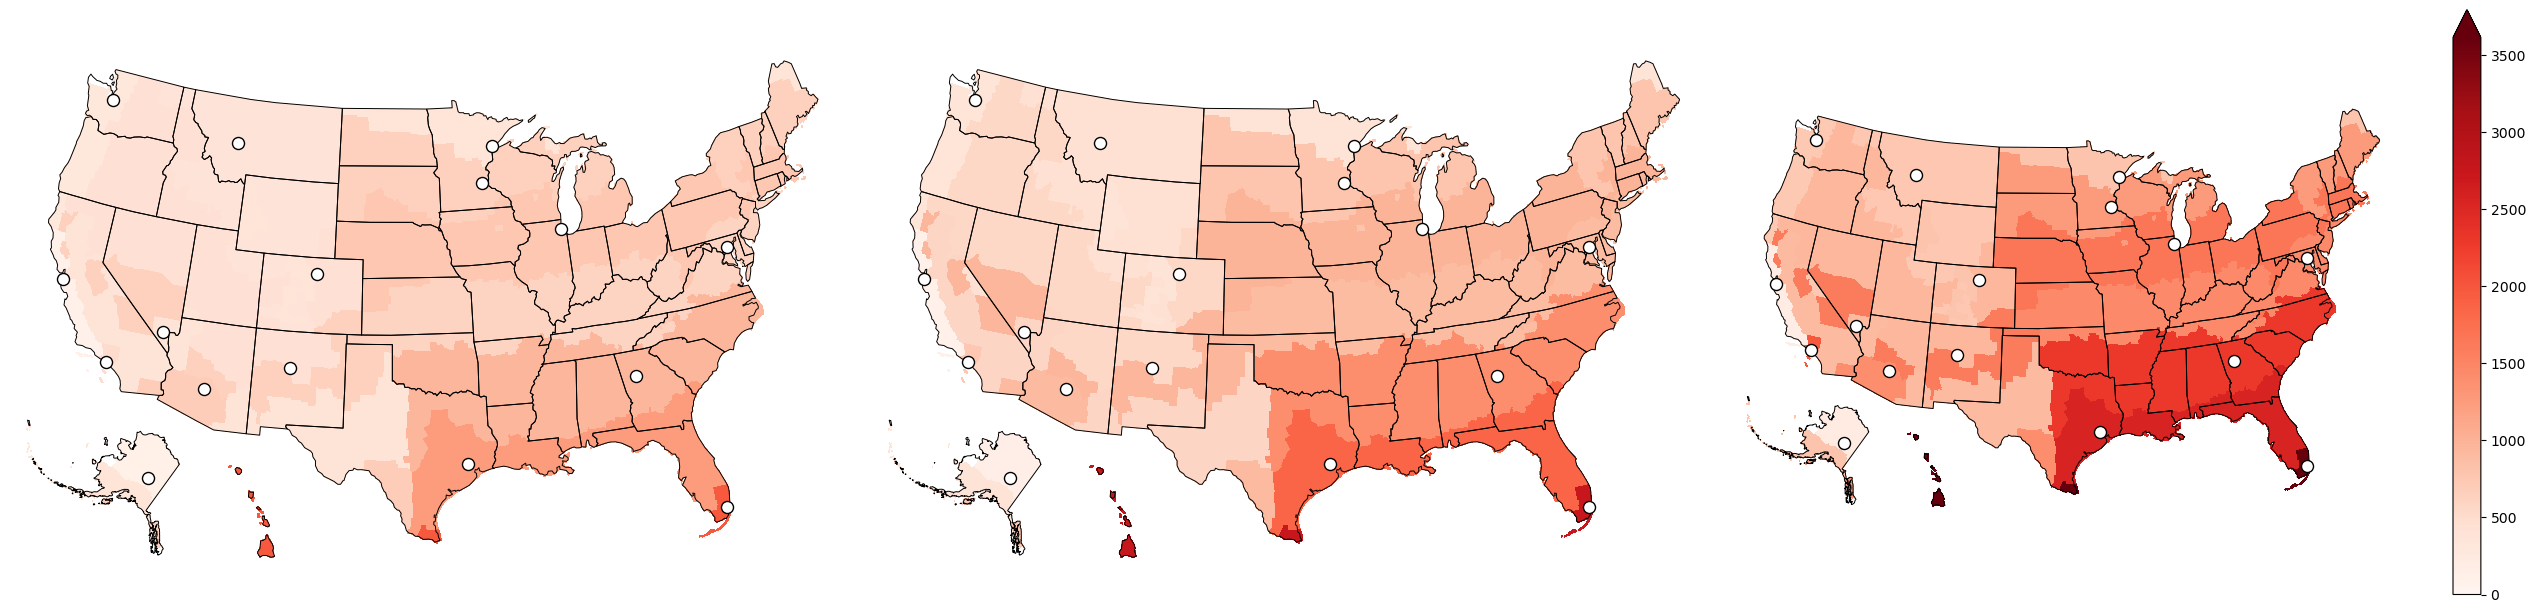

In [8]:

lgd_label = r'Shift in Number of Days over 26˚'
lgd_kw = {'location': 'right',
        'pad': -0.02,
        'shrink': 0.35,
        'extend': 'max',
        'spacing': 'uniform',
        'label': lgd_label,
        }

cmap = 'Reds'
plot_cols = ['D_n26_126','D_n26_245','D_n26_585']
vmin = 0# -zones[plot_cols].max().max()
vmax = zones[plot_cols].max().max()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(26,12))
pf.plot_us_map_heatmap(zones, plot_cols[0], lgd_label, lgd=False, ax=ax1, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, plot_cols[1], lgd_label, lgd=False, ax=ax2, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, plot_cols[2], lgd_label, lgd=False, ax=ax3, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
patch_col = ax1.collections[0]
cb = fig.colorbar(patch_col, ax=ax3, shrink=0.5, extend='max')
plt.show() 

# Dark hours

In [34]:

def calculate_ratio_hours(tmy_file):
    
    location = utils.tmy_location(tmy_file)
    tmy = utils.tmy_to_dataframe(tmy_file)
    solar_df = pvlib.solarposition.get_solarposition(tmy.index, #pd.DatetimeIndex
                                                    location['lat'], 
                                                    location['lon'],
                                                    altitude=location['elevation'], #[m]
                                                    pressure=tmy['atmos_Pa'], #[Pa]
                                                    method='nrel_numpy', 
                                                    temperature=tmy['drybulb_C'] #[C]
                                                    )


    surface_tilt = 45
    surface_azimuth = 180
    solar_zenith = solar_df['zenith']
    solar_azimuth = solar_df['azimuth']
    dni = tmy['dirnorrad_Whm2']
    ghi =tmy['glohorrad_Whm2']
    dhi = tmy['difhorrad_Whm2']
    dni_extra = pvlib.irradiance.get_extra_radiation(tmy.index)
    poa_beam = pvlib.irradiance.beam_component(surface_tilt, 
                                            surface_azimuth, 
                                            solar_zenith, 
                                            solar_azimuth,
                                            dni).fillna(0)
    poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(surface_tilt, 
                                                    surface_azimuth, 
                                                    solar_zenith, 
                                                    solar_azimuth,
                                                    dni, ghi, dhi, 
                                                    dni_extra=dni_extra, 
                                                    airmass=None, 
                                                    model='perez').fillna(0)


    poa_ratio = pd.Series(np.where(poa_sky_diffuse==0,0, poa_beam / poa_sky_diffuse))
    return np.sum([poa_ratio>1])

In [46]:
delta_dict = {}

for cz in pf.get_cz_list():
    delta_dict[cz] = {}
    hist_epw_file = [f for f in hist_epw_files if cz in f][0]
    tmy_df_hist = utils.tmy_to_dataframe(hist_epw_file)
    # hist_var = sum(tmy_df_hist[tmy_df_hist['dirnorrad_Whm2']>0]['dirnorrad_Whm2'])
    hist_var = calculate_ratio_hours(hist_epw_file)
    ssp126_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp126', 'EPWs', 'ssp126_50*.epw'))
    ssp245_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp245', 'EPWs', 'ssp245_50*.epw'))
    ssp585_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp585', 'EPWs', 'ssp585_50*.epw'))
    
    for year in pf.get_years():
        f_126 = pf.find_file(ssp126_epw_files, pf.get_year_bands(year))
        f_245 = pf.find_file(ssp245_epw_files, pf.get_year_bands(year))
        f_585 = pf.find_file(ssp585_epw_files, pf.get_year_bands(year))
        
        for ssp in [f_126, f_245, f_585]:
            # n_hours_g_5_fut = sum(utils.tmy_to_dataframe(ssp)['opaqskycvr_tenths']>5)
            tmy_df_fut = utils.tmy_to_dataframe(ssp)
            # fut_var = sum(tmy_df_fut[tmy_df_fut['dirnorrad_Whm2']>0]['dirnorrad_Whm2'])
            fut_var = calculate_ratio_hours(ssp)

            scenario = ssp.split(os.sep)[-3]
            delta_dict[cz].update({f'{scenario}_{year}':fut_var - hist_var})

dark_hours_df = pd.DataFrame(delta_dict).transpose()

delta_126 = dark_hours_df[['ssp126_2080']].to_dict()['ssp126_2080']
delta_245 = dark_hours_df[['ssp245_2080']].to_dict()['ssp245_2080']
delta_585 = dark_hours_df[['ssp585_2080']].to_dict()['ssp585_2080']

zones['D_dni_126'] = zones['climate_zone'].map(delta_126)
zones['D_dni_245'] = zones['climate_zone'].map(delta_245)
zones['D_dni_585'] = zones['climate_zone'].map(delta_585)

zones.head()

,GEOID,Country,State,IECC15,IECC21,BA15,BA21,Moisture15,Moisture21,geometry,...,cz_color,D_n26_126,D_n26_245,D_n26_585,D_n5_126,D_n5_245,D_n5_585,D_dni_126,D_dni_245,D_dni_585
0,G37017,Bladen,North Carolina,3.0,3,Mixed-Humid,Mixed-Humid,A,a,"POLYGON ((1908594.508 -888691.896, 1917226.443...",...,#c55912,960,1406,2298,0,0,28,-483,-496,-492
1,G37167,Stanly,North Carolina,3.0,3,Mixed-Humid,Mixed-Humid,A,a,"POLYGON ((1759107.569 -883582.059, 1769852.587...",...,#c55912,960,1406,2298,0,0,28,-483,-496,-492
2,G39153,Summit,Ohio,5.0,5,Cold,Cold,A,a,"POLYGON ((1518816.335 -259402.244, 1515622.890...",...,#32a02e,761,979,1679,9,0,64,-602,-639,-686
3,G42113,Sullivan,Pennsylvania,5.0,5,Cold,Cold,A,a,"POLYGON ((1897285.293 -108013.083, 1945669.474...",...,#32a02e,761,979,1679,9,0,64,-602,-639,-686
4,G48459,Upshur,Texas,3.0,3,Hot-Humid,Hot-Humid,A,a,"POLYGON ((456109.472 -1356476.609, 454827.653 ...",...,#c55912,960,1406,2298,0,0,28,-483,-496,-492


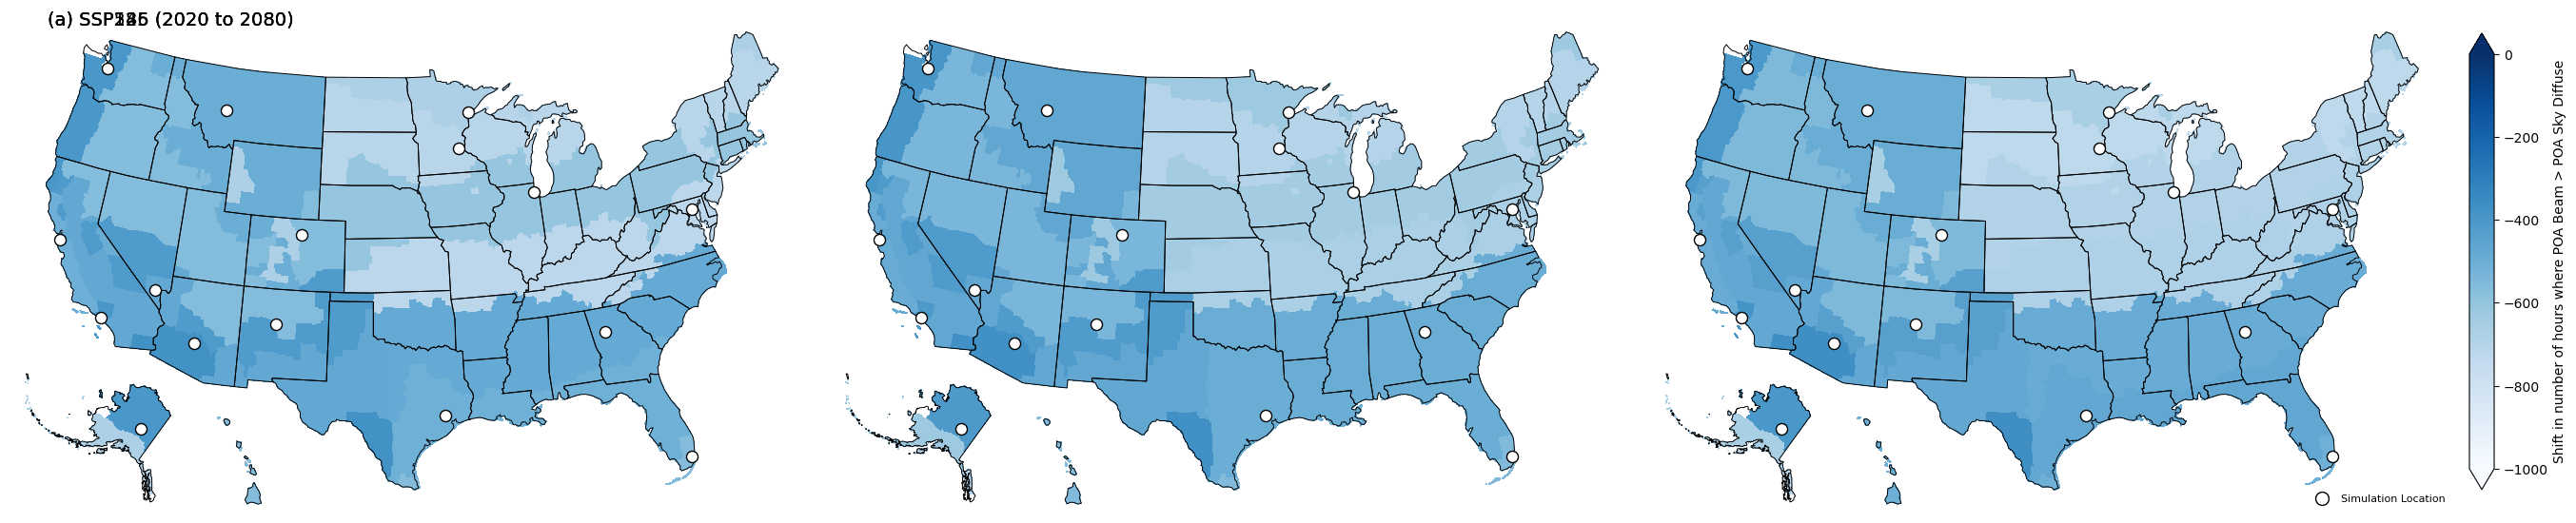

In [79]:

lgd_label = r'Shift in number of hours where POA Beam > POA Sky Diffuse'
lgd_kw = {'location': 'right',
        'pad': -0.02,
        'shrink': 0.35,
        'extend': 'max',
        'spacing': 'uniform',
        'label': lgd_label,
        }

cmap = 'civids_r'
plot_cols = ['D_dni_126','D_dni_245','D_dni_585']
vmin = -1000# -zones[plot_cols].max().max()
vmax = 0#-zones[plot_cols].max().max()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(26,12))
pf.plot_us_map_heatmap(zones, plot_cols[0], lgd_label, lgd=False, ax=ax1, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, plot_cols[1], lgd_label, lgd=False, ax=ax2, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, plot_cols[2], lgd_label, lgd=False, ax=ax3, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
# patch_col = ax1.collections[0]
# cb = fig.colorbar(patch_col, ax=ax3, shrink=0.5, extend='max')

ax1.text(0.2, 0.98, '(a) SSP126 (2020 to 2080)', fontsize=14,
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax2.text(0.2, 0.98, '(a) SSP245 (2020 to 2080)', fontsize=14,
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax3.text(0.2, 0.98, '(a) SSP585 (2020 to 2080)', fontsize=14,
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)



cbar_ax = fig.add_axes([1.0, 0.30, 0.01, 0.4])
fig.colorbar(patch_col, cax=cbar_ax, extend='both', label=lgd_label)

lgd_el_tmy = pf.build_lgd(
            [('white', 'k')], ['Simulation Location'], element_type='marker')
ax3.legend(handles=lgd_el_tmy, loc='lower right', frameon=False, title='',
                        fontsize=8)

plt.show() 